<a href="https://colab.research.google.com/github/Turakulov/Python/blob/master/richtracks%20model%20training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

<div class="alert alert-block alert-info">
<h4>Имеется 3 датасета:</h4>
<p>1) Данные треков - Richtracks (описание приложено)</p>
<p>2) Данные точек этих треков - IncomingTrackPoints (описание также приложено)</p>
<p>3) Наборы токен-платформа (iOS или Android)</p>
</div>

<div class="alert alert-block alert-info">
<h4>Задание:</h4> 
<p>1) Переведите все параметры в одинаковую размерность</p>
<p>2) В richtracks для каждого трека есть поле TrackOrigin, которое описывает кем была произведена поездка: владельцем смартфона или нет. Задание: постройте модель, предсказывающую на основании данных из входящих точек, была ли поездка пассажирской или нет.</p>
</div>

In [0]:
# Pandas and numpy for data manipulation 
import pandas as pd
from pandas.api.types import infer_dtype
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score,roc_auc_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 100 columns of a dataframe
pd.set_option('display.max_columns', 100)


# Uploading files

In [0]:
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rich_tracks_2.csv', encoding='utf-8') 
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/inc_points_2.csv', encoding='utf-8') 
os = pd.read_csv('/content/drive/My Drive/Colab Notebooks/os.csv', encoding='utf-8') 

In [3]:
df1.head()

,Id,TrackToken,DeviceToken,IncomingTrackId,StartDate,EndDate,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,TrackOrigin,OriginChanged,AddressStart,AddressFinish,DistanceGPS,Urban,Region,Country,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,OriginalTrackOrigin,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,Prediction,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,Shared,CityStart,CityFinish,UpdateDT,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,RatingCornering,VehicleId,BeaconId,DeviationRatio,DeviationMeters
0,5148865,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,20702795,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,4.203323,10.516667,2,1,1.45,1.316667,OriginalDriver,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",4.096,True,Республика Татарстан,Россия,0.0,2.50,5.000000,5.0,0.650,0.818,0.812,NaN,1061,0.000000,0.0,10.516666,3.75,0.20,0.800,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,1.0,1.0,111.0,6.0,120.0,7.0,NaN,NaN,NaN,0.0,7.390443
1,5148032,4BDD2EE6-FF53-4762-83DA-35A849935A99,669AFC5F-921C-40B9-B090-587BC95D34C2,20691750,2019-10-17 17:35:30.0000000 +05:00,2019-10-17 18:00:56.0000000 +05:00,414.076500,25.433333,0,1,4.75,0.000000,OriginalDriver,False,"улица Труда 166/1, Центральный район, Челябинс...","улица Блюхера 69А, Советский район, Челябинск,...",6.233,True,Челябинская область,Россия,5.0,5.00,4.993904,5.0,0.608,0.000,0.000,NaN,1061,1.033333,0.0,24.400000,3.75,1.00,1.000,1.0,0.875,70.917030,27.351787,0.000000,0.000,0.000,1.0,NaN,100.0,100.0,100.0,75.0,92.500000,0.0,Челябинск,Челябинск,2019-10-17 13:06:47.537,0.0,0.0,16.0,0.0,29.0,0.0,NaN,NaN,NaN,0.0,17.956039
2,5147957,A0624E01-25FD-4B2D-A56E-617BB2546526,55D0C3A4-9E5B-4B57-BC22-E986158707F8,20690445,2019-10-17 16:35:25.0000000 +04:00,2019-10-17 16:49:04.0000000 +04:00,6.498145,13.650000,0,0,5.00,1.366667,OriginalDriver,False,"улица Мира 64, Волжский, Волгоградская область...","улица Пушкина 17, Волжский, Волгоградская обла...",7.135,True,Волгоградская область,Россия,5.0,5.00,5.000000,5.0,1.990,0.164,0.000,NaN,1061,0.000000,0.0,13.650000,5.00,1.00,1.000,1.0,1.000,63.825897,38.091320,0.000000,0.819,0.000,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Волжский,Волжский,2019-10-17 12:58:55.733,0.0,0.0,4.0,1.0,63.0,4.0,NaN,NaN,NaN,0.0,18.219858
3,5147902,D233A0EB-2D09-47F3-B0EB-3D852434F982,8E58407D-8933-4AFB-B158-81FF4548AEC4,20689861,2019-10-17 19:35:07.0000000 +07:00,2019-10-17 19:40:59.0000000 +07:00,1.148526,5.866667,0,1,4.75,1.983333,OriginalDriver,False,"Рентгеновская улица 77, Заельцовский район, Но...","Уфимская улица 29, Заельцовский район, Новосиб...",1.056,True,Новосибирская область,Россия,5.0,5.00,3.000000,5.0,0.000,0.000,0.000,NaN,1061,5.866667,0.0,0.000000,3.75,1.00,1.000,1.0,0.875,54.683998,18.418604,0.000000,0.551,0.000,1.0,NaN,100.0,100.0,100.0,50.0,85.000008,0.0,Новосибирск,Новосибирск,2019-10-17 12:49:51.397,0.0,0.0,37.0,20.0,51.0,23.0,NaN,NaN,NaN,0.0,5.328696
4,5150087,0195F786-966E-49AF-9326-82697CCC9011,0CE60F80-6BA3-4706-916B-BA864A434F46,20713090,2019-10-17 15:35:03.0000000 +03:00,2019-10-17 16:09:45.0000000 +03:00,8.160865,34.700000,2,1,2.65,0.000000,OriginalDriver,False,"улица Некрасова 56, Центральный район, Санкт-П...","Кузнецовская улица 31 лит А, Московский район,...",7.983,True,Санкт-Петербург,Россия,2.3,2.52,5.000000,5.0,0.883,0.191,0.226,NaN,1061,0.000000,0.0,34.700001,3.83,0.46,0.805,1.0,0.885,74.087929,31.291415,0.000000,0.000,0.000,1.0,NaN,100.0,100.0,10

In [4]:
df2.head()

,IncomingTrackId,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23.0000000 +03:00,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434
1,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23.0000000 +03:00,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091
2,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315734,0.913208,0.488998,0.308365
3,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315735,0.930328,0.396133,-0.145203
4,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315736,0.887436,0.647537,0.245926


In [5]:
os.head()

,DeviceToken,os_version
0,2A768BE9-24E4-4274-AE30-03D07EE1D5B8,Android
1,CA447E48-E1C4-4F06-BA03-35C029C7E0F8,Android
2,EB26DDE2-8C75-439B-8FDA-AE838E15E944,iOS
3,3135D84F-1A08-4CBF-9439-D6C1BA58F4AA,iOS
4,16B59F05-9FEC-40DA-A181-C42B1AA2B517,Android


In [0]:
android = os[os["os_version"] == "Android"][['DeviceToken']]
ios = os[os["os_version"] == "iOS"][['DeviceToken']]

In [0]:
data = df1.copy()

In [8]:
data["os"] = np.nan
data.loc[np.in1d(data.DeviceToken, android.DeviceToken), "os"] = "Android"
data.loc[np.in1d(data.DeviceToken, ios.DeviceToken), "os"] = "iOS"
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 65 columns):
Id                        4000 non-null int64
TrackToken                4000 non-null object
DeviceToken               4000 non-null object
IncomingTrackId           4000 non-null int64
StartDate                 4000 non-null object
EndDate                   4000 non-null object
Distance                  4000 non-null float64
Duration                  4000 non-null float64
AccelerationCount         4000 non-null int64
DecelerationCount         4000 non-null int64
Rating                    4000 non-null float64
PhoneUsage                4000 non-null float64
TrackOrigin               4000 non-null object
OriginChanged             4000 non-null bool
AddressStart              3999 non-null object
AddressFinish             3999 non-null object
DistanceGPS               4000 non-null float64
Urban                     4000 non-null bool
Region                    2824 non-null object
Cou

# There are a lot of missing values. So we have to reduce them

In [0]:
data = data.merge(df2, how='inner')

# Merging datasets in order to simplify actions

In [10]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(data)

Selected dataframe has 76 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
BeaconId,3791240,100.0
Prediction,3791240,100.0
VehicleId,3791240,100.0
RatingCornering,3073692,81.1
OriginalTrackOrigin,2759677,72.8
Region,731466,19.3
KPhoneUsage,717548,18.9
KOverSpeed,717548,18.9
KAcceleration,717548,18.9
KTimeOfDay,717548,18.9


In [0]:
data['Urban']=data['Urban'].replace({True:1, False:0})
data['OriginChanged']=data['OriginChanged'].replace({True:1, False:0})
data['os']=data['os'].replace({'Android':1, 'iOS':0})

# We have to implement label encoding to get rid of several categorical columns. Simply saying we change boolean or unique values to decimals like 0 and 1

In [0]:
cat_list = ['TrackOrigin']
data['TrackOrigin'] = data['TrackOrigin'].replace({'OriginalDriver': 0, 'Taxi': 0,'Passanger': 1})

# Implementing label encoding to the target prediction column. Let me remind you that the column `TrackOrigin` that our model have to predict accurately.

In [13]:
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))
data = data.drop(columns = list(missing_columns))
data.shape

Selected dataframe has 76 columns.
There are 18 columns that have missing values.
We will remove 5 columns.


(3791240, 71)

# We select only integer and float columns because the remaining categorical columns such as city/address do not carry any meaning.

In [14]:
newdf = data.drop(columns=['Shared'])

numerics = ['int64','float64']
newdf = newdf.select_dtypes(include=numerics)
newdf.head()

,Id,IncomingTrackId,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,TrackOrigin,OriginChanged,DistanceGPS,Urban,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,DeviationRatio,DeviationMeters,os,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.863077,52.227935,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434
1,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.863077,52.227935,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091
2,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315734,0.913208,0.488998,0.308365
3,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315735,0.930328,0.396133,-0.145203
4,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,0,0,4.096,1,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315736,0.887436,0.647537,0.245926


# Due to the fact that each track has multiple data points corresponding to it , many columns are almost same with a slight change in hundredths

In [0]:
newdf = newdf.groupby('Id').median().reset_index()

# Finding the median value for each track id.

In [16]:
newdf.shape

(2587, 58)

# Only 58 columns left with 2587 rows

In [17]:
categorical = data.select_dtypes(include = ('object','bool'))
categorical.head(3)

,TrackToken,DeviceToken,StartDate,EndDate,AddressStart,AddressFinish,Region,Country,CityStart,CityFinish,UpdateDT,PointDate
0,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,2019-10-17 15:35:23.0000000 +03:00
1,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,2019-10-17 15:35:23.0000000 +03:00
2,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,2019-10-17 15:35:34.0000000 +03:00


# We can see now that remaining categorical values are useless for our model

In [18]:
y = newdf['TrackOrigin'].values
newdf = newdf.drop(columns=['TrackOrigin'])
y

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
missing_values_table(newdf)

Selected dataframe has 57 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
KOverSpeed,546,21.1
KAcceleration,546,21.1
KTimeOfDay,546,21.1
KDeceleration,546,21.1
KPhoneUsage,546,21.1
DeviationRatio,7,0.3
DeviationMeters,7,0.3


# Surprise!!! There are several columns with missing values. To get rid of them we have to put median value of the column to each NAN row in our dataset.

In [0]:
newdf.KOverSpeed[newdf.KOverSpeed.isna()]=np.random.normal(loc=newdf.KOverSpeed.median(), scale=3, size=newdf.KOverSpeed[newdf.KOverSpeed.isna()].shape[0])
newdf.KAcceleration[newdf.KAcceleration.isna()]=np.random.normal(loc=newdf.KAcceleration.median(), scale=3, size=newdf.KAcceleration[newdf.KAcceleration.isna()].shape[0])
newdf.KTimeOfDay[newdf.KTimeOfDay.isna()]=np.random.normal(loc=newdf.KTimeOfDay.median(), scale=3, size=newdf.KTimeOfDay[newdf.KTimeOfDay.isna()].shape[0])
newdf.KDeceleration[newdf.KDeceleration.isna()]=np.random.normal(loc=newdf.KDeceleration.median(), scale=3, size=newdf.KDeceleration[newdf.KDeceleration.isna()].shape[0])
newdf.KPhoneUsage[newdf.KPhoneUsage.isna()]=np.random.normal(loc=newdf.KPhoneUsage.median(), scale=3, size=newdf.KPhoneUsage[newdf.KPhoneUsage.isna()].shape[0])
newdf.DeviationRatio[newdf.DeviationRatio.isna()]=np.random.normal(loc=newdf.DeviationRatio.median(), scale=3, size=newdf.DeviationRatio[newdf.DeviationRatio.isna()].shape[0])
newdf.DeviationMeters[newdf.DeviationMeters.isna()]=np.random.normal(loc=newdf.DeviationMeters.median(), scale=3, size=newdf.DeviationMeters[newdf.DeviationMeters.isna()].shape[0])


In [0]:
X_train, X_test, y_train, y_test = train_test_split(newdf, y, test_size=0.3, random_state=42, stratify = y) 

# Splitting data
# `X_train` and `y_train` become data for the machine learning, capable to create a model. Once the model is created, input `X_test` and the output should be equal to `y_test`. The more closely the model output is to `y_test`: the more accurate the model is.

In [0]:
scaler_std = StandardScaler()

X_train_scaled = scaler_std.fit_transform(X_train)
X_test_scaled = scaler_std.transform(X_test)

# Feature scaling with MinMaxScaler 
scaler_mm = MinMaxScaler() 
X_train_scaled = scaler_mm.fit_transform(X_train_scaled)
X_test_scaled = scaler_mm.transform(X_test_scaled)

# Standard scaler - standardize features by removing the mean and scaling to unit variance

# MinMax scaler - transform features by scaling each feature to a given range.

# Существует много сравнительных обзоров, которые помогут сориентироваться при выборе алгоритма, но я предпочитаю попробовать в работе несколько и посмотреть, какой лучше. Машинное обучение по большей части основывается на эмпирических, а не теоретических результатах, и практически невозможно заранее понять, какая модель окажется точнее.

In [23]:
model_dict = {
   'LR': LogisticRegression(random_state=42),
   'LDA': LDA(),
   'SVC': SVC(random_state=42),
   'KNN': KNeighborsClassifier(),
   'DT': DecisionTreeClassifier(random_state=42),
   'RF': RandomForestClassifier(random_state=42),
   'GBC': GradientBoostingClassifier(random_state=42)
}

score_list = []

for model in model_dict:
    model_dict[model].fit(X_train_scaled, y_train)
    y_pred_test = model_dict[model].predict(X_test_scaled)
    accuracy = accuracy_score(y_pred = y_pred_test, y_true = y_test)
    precision = precision_score(y_pred = y_pred_test, y_true = y_test)
    recall = recall_score(y_pred = y_pred_test, y_true = y_test)
    score_list.append((accuracy, precision, recall))

for model, scores in zip(model_dict.keys(), score_list):
    print(f'{model}: \n\t accuracy: {np.round(scores[0], 4)} \n\t precision: {np.round(scores[1], 4)} \n\t recall: {np.round(scores[2], 4)}')

LR: 
	 accuracy: 0.9614 
	 precision: 0.8343 
	 recall: 0.9932
LDA: 
	 accuracy: 0.9588 
	 precision: 0.8212 
	 recall: 1.0
SVC: 
	 accuracy: 0.9588 
	 precision: 0.8212 
	 recall: 1.0
KNN: 
	 accuracy: 0.9575 
	 precision: 0.8562 
	 recall: 0.932
DT: 
	 accuracy: 0.9678 
	 precision: 0.9178 
	 recall: 0.9116
RF: 
	 accuracy: 0.964 
	 precision: 0.8521 
	 recall: 0.9796
GBC: 
	 accuracy: 0.9691 
	 precision: 0.8773 
	 recall: 0.9728


# One of the best results with data preprocessing is GradientBoostingClassifier
# `accuracy: 0.9717 precision: 0.8882 recall: 0.9728`

# Критерии качества можно представить в виде формул: 
# $accuracy = \frac{TP+TN}{TP+TN+FP+FN}$ - показывает долю правильных ответов системы; 
# $precision = \frac{TP}{TP+FP}$ - показывает точность предсказания системы (если система сказала, что поездка пассажирская, насколько ей можно доврять); 
# $recall = \frac{TP}{TP+FN}$ - показывает полноту ответов системы (сколько пассадирскиз поездок она найдет из всех предъявленных поездок).


# We have to implement Principal Component Analysis (Метод главных компонент) in order to reduce the dimension of the dataset.

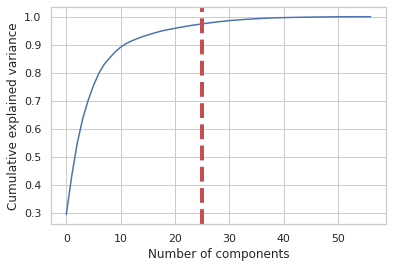

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.293173,0.293173
1,0.430568,0.137395
2,0.546593,0.116025
3,0.633874,0.087280
4,0.699829,0.065955


In [24]:
pca_test = PCA(n_components=57)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=25, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head())

# From now we will use only 25 main components. So, we have decreased the dataset dimension more than twice from 57 to 25.

In [0]:
pca = PCA(n_components=25)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [26]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=newdf.columns, index=pca_dims)
pca_test_df.head().T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4
Id,0.001045,-0.000176,1.521894e-02,-0.012049,-0.032260
IncomingTrackId,0.005188,0.003032,2.556132e-02,-0.004356,-0.040758
Distance,0.003936,0.008090,-6.078987e-04,-0.000421,0.003980
Duration,0.056158,-0.008389,-5.613565e-03,-0.013951,0.010202
AccelerationCount,0.014146,-0.019499,3.951074e-04,0.027100,0.014398
DecelerationCount,0.022536,-0.028556,-1.558966e-03,0.031745,0.023196
Rating,-0.207690,0.071334,8.901415e-02,-0.350481,-0.046433
PhoneUsage,0.004424,-0.002355,1.928306e-03,-0.000356,0.000514
OriginChanged,0.244368,0.232744,4.256392e-01,0.486477,-0.435187
DistanceGPS,0.070311,-0.005071,-1.393988e-04,-0.036882,-0.006694


In [27]:
GBC_pca = GradientBoostingClassifier()
GBC_pca.fit(X_train_scaled_pca, y_train)
display(GBC_pca.score(X_train_scaled_pca, y_train))

0.9977900552486187

# Here we can see that our model is very accurate because of the almost 97% score.

# But what if that is not the limit? 
# Let's try to configure hyperparameters of the model using RandomizedSearchCV

In [28]:
%%time

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
loss = ['deviance', 'exponential']

param_dist = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'loss': loss}

rs = RandomizedSearchCV(GradientBoostingClassifier(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=42)
rs.fit(X_train_scaled_pca, y_train)

print(rs.best_score_)
print(rs.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


0.9651924337107692
{'n_estimators': 700, 'min_samples_split': 44, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_depth': 11, 'loss': 'deviance', 'learning_rate': 0.9}
CPU times: user 1.78 s, sys: 345 ms, total: 2.12 s
Wall time: 1min 18s


In [29]:
GBC_hp = GradientBoostingClassifier(n_estimators = 700, 
                                    min_samples_split = 44,
                                    min_samples_leaf = 7,
                                    max_features = 'log2',
                                    max_depth = 11,
                                    loss = 'deviance', 
                                    learning_rate = 0.9)

GBC_hp.fit(X_train_scaled, y_train)
y_test_hp = GBC_hp.predict(X_test_scaled)
accuracy = round(accuracy_score(y_test_hp, y_test), 4)
precision = round(precision_score(y_test_hp, y_test), 4)
recall = round(recall_score(y_test_hp, y_test), 4)
print(f'\n\t accuracy: {accuracy} \n\t precision: {precision} \n\t recall: {recall}')



	 accuracy: 0.9665 
	 precision: 0.966 
	 recall: 0.8712


# Here we can see that there is no need for configuring hyperparameteres 

# Let's measure the quality of the model by samples with default hyperparameteres




In [0]:
y_pred_test = GBC_pca.predict(X_test_scaled_pca)

In [31]:
def binary_classification_performance(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),4)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),4)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),4)
    f1_score = round(2*precision*recall/(precision + recall),4)
    specificity = round(tn/(tn+fp),4)
    npv = round(tn/(tn+fn),4)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),4)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision' : [precision],
                         'Recall' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result


binary_classification_performance(y_test, y_pred_test)

,Accuracy,Precision,Recall,f1 score,AUC_ROC,Specificty,NPV,True Positive,True Negative,False Positive,False Negative
0,0.9601,0.8766,0.9184,0.897,0.9441,0.9698,0.9807,135,611,19,12


<div class="alert alert-block alert-green">
<h2> Finally, we can see that our model predicts accurately.</h2>
</div>